In [28]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
file_path = 'C:/Users/paula/OneDrive/Desktop/databases/retail_store_inventory.csv'

In [32]:
df = pd.read_csv(file_path)

In [34]:
# Filling missing values

In [36]:
imputer = SimpleImputer(strategy='mean')
df['Inventory Level'] = imputer.fit_transform(df[['Inventory Level']])
df['Units Sold'] = imputer.fit_transform(df[['Units Sold']])
df['Competitor Pricing'] = imputer.fit_transform(df[['Competitor Pricing']])
df['Discount'] = imputer.fit_transform(df[['Discount']])

In [38]:
# Filling categorical missing values

In [40]:
df['Weather Condition'] = df['Weather Condition'].fillna('Unknown')
df['Holiday/Promotion'] = df['Holiday/Promotion'].fillna(0)

In [42]:
# Converting Date to datetime

In [44]:
df['Date'] = pd.to_datetime(df['Date'])

In [46]:
# Creating lag features for time series

In [48]:
for lag in range(1, 8):
    df[f'Lag_{lag}_Sales'] = df['Units Sold'].shift(lag)

In [50]:
 # Creating rolling window features

In [52]:
df['Rolling_Mean_7'] = df['Units Sold'].rolling(window=7).mean()
df['Rolling_Std_'] = df['Units Sold'].rolling(window=7).std()

In [54]:
# Normalizing numeric data

In [56]:
scaler = StandardScaler()
df[['Units Sold', 'Inventory Level', 'Competitor Pricing', 'Discounts']] = scaler.fit_transform(
    df[['Units Sold', 'Inventory Level', 'Competitor Pricing', 'Discount']]
)

In [58]:
# Droping rows with NaNs created by lagging

In [60]:
df.dropna(inplace=True)

In [62]:
# Display prepared data

In [64]:
print(df.head())

         Date Store ID Product ID     Category Region  Inventory Level  \
7  2022-01-01     S001      P0008     Clothing  North         0.812091   
8  2022-01-01     S001      P0009  Electronics   West        -0.703893   
9  2022-01-01     S001      P0010         Toys  South        -1.281044   
10 2022-01-01     S001      P0011    Furniture  South        -0.126741   
11 2022-01-01     S001      P0012     Clothing   West        -1.604248   

    Units Sold  Units Ordered  Demand Forecast  Price  ...  Lag_1_Sales  \
7     1.611617             54           329.73  97.99  ...         97.0   
8     0.353797            135           174.15  20.74  ...        312.0   
9    -0.995834            196            24.47  59.99  ...        175.0   
10    0.124268            153           152.74  58.53  ...         28.0   
11   -1.032558             70            26.75  58.25  ...        150.0   

   Lag_2_Sales  Lag_3_Sales  Lag_4_Sales Lag_5_Sales  Lag_6_Sales  \
7        128.0         14.0        

In [66]:
# ARIMA Model

In [68]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [69]:
# Aggregating time series data

In [70]:
time_series = df.groupby('Date')['Units Sold'].sum()

In [74]:
# Auto ARIMA to find optimal parameters

In [76]:
model_arima = auto_arima(time_series, seasonal=True, m=7, trace=True, suppress_warnings=True)
model_arima.fit(time_series)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5365.545, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5369.102, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5369.097, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5363.545, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=5367.475, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5367.478, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=5369.441, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5367.165, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=5367.158, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=5369.145, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7]          
Total fit time: 2.376 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [77]:
# Forecasting the next 30 days

In [78]:
forecast_arima = model_arima.predict(n_periods=30)

In [79]:
# Plot forecast

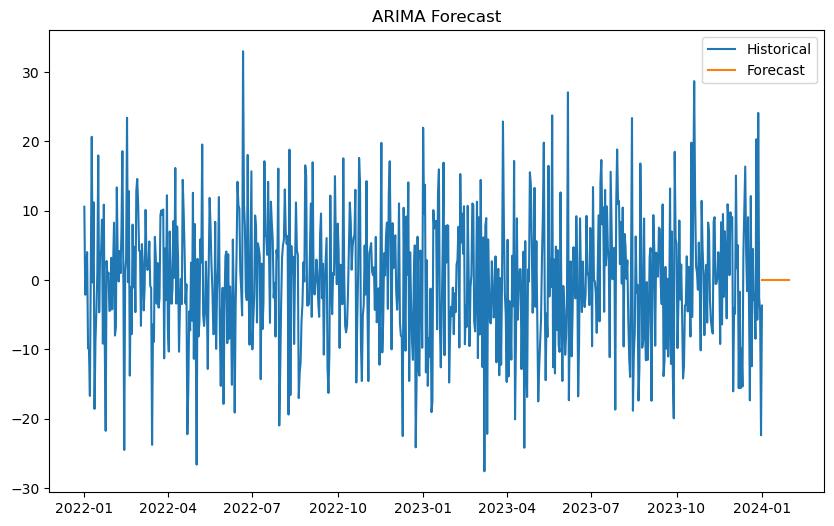

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Historical')
plt.plot(pd.date_range(start=time_series.index[-1], periods=30, freq='D'), forecast_arima, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [86]:
# LSTM Model

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

In [132]:
# Preparing LSTM data

In [92]:
scaler = MinMaxScaler()
time_series_scaled = scaler.fit_transform(time_series.values.reshape(-1, 1))

In [94]:
# Creating
sequences

In [100]:
sequence_length = 30
X, y = [], []
for i in range(sequence_length, len(time_series_scaled)):
    X.append(time_series_scaled[i-sequence_length:i])
    y.append(time_series_scaled[i])
X, y = np.array(X), np.array(y)

In [102]:
# Train-test split

In [104]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [106]:
# LSTM Model

In [116]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


C:\Users\paula\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1989 - val_loss: 0.0773
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0554 - val_loss: 0.0274
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0298 - val_loss: 0.0268
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 - val_loss: 0.0267
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.0267
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - val_loss: 0.0266
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - val_loss: 0.0267
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280 - val_loss: 0.0267
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258 - val_loss: 0.0266
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0275 - val_loss: 0.0265
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - val_loss: 0.0265
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - val_loss: 0.0265

In [128]:
# Forecasting

In [120]:
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [122]:
# Plot results

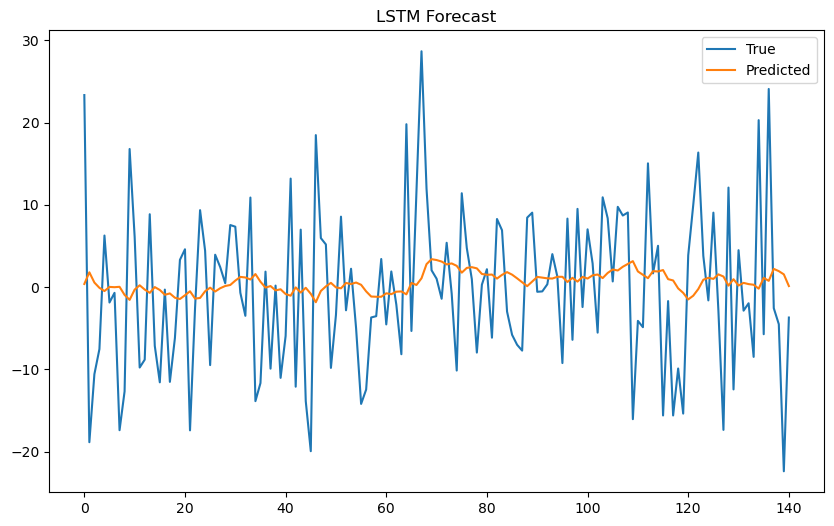

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(predictions_rescaled, label='Predicted')
plt.legend()
plt.title('LSTM Forecast')
plt.show()

In [126]:
# Inventory Optimization with Simulation

In [136]:
# Reordering policy based on rolling average demand

In [140]:
df['Reorder Point'] = df['Rolling_Mean_7'] * 1.5  # Adjust multiplier based on lead time
df['Reorder'] = np.where(df['Inventory Level'] < df['Reorder Point'], 1, 0)

In [142]:
# Calculating stockouts

In [144]:
df['Stockout'] = np.where(df['Inventory Level'] == 0, 1, 0)

In [146]:
# Simulation: Analyzing inventory performance under different policies

In [150]:
print(f"Total Stockouts: {df['Stockout'].sum()}")
print(f"Reorders Triggered: {df['Reorder'].sum()}")

Total Stockouts: 0
Reorders Triggered: 73093


In [152]:
# Plot stock levels vs. reorder point

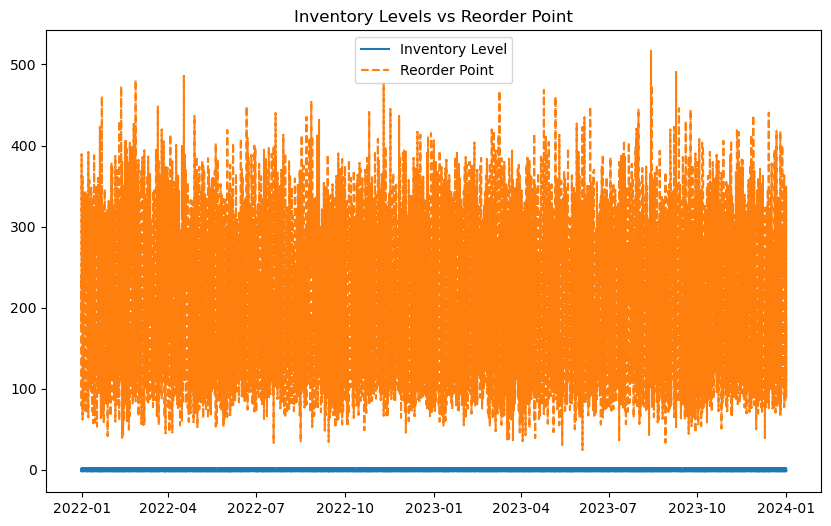

In [158]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Inventory Level'], label='Inventory Level')
plt.plot(df['Date'], df['Reorder Point'], label='Reorder Point', linestyle='--')
plt.legend()
plt.title('Inventory Levels vs Reorder Point')
plt.show()

In [160]:
# Dynamic Pricing with Random Forest

In [162]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [200]:
# Selecting features and target for pricing model

In [194]:
pricing_features = ['Competitor Pricing', 'Discounts', 'Holiday/Promotion', 'Rolling_Mean_7']
X = df[pricing_features]
y = df['Units Sold']

In [196]:
# Train-test split

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [202]:
# Training Random Forest

In [204]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [206]:
# Predicting and evaluating

In [208]:
y_pred = rf.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

RMSE: 0.9784917903939764


In [210]:
# Feature importance

In [214]:
importances = rf.feature_importances_
for i, feature in enumerate(pricing_features):
    print(f"{feature}: {importances[i]:.4f}")

Competitor Pricing: 0.4628
Discounts: 0.0890
Holiday/Promotion: 0.0384
Rolling_Mean_7: 0.4098


In [216]:
# Interactive Dashboard with Plotly Dash

In [222]:
import dash
from dash import dcc, html
import plotly.express as px

In [224]:
# Interactive time series plot

In [228]:
fig = px.line(df, x='Date', y='Units Sold', title='Interactive Sales Trends')

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Sales Dashboard"),
    dcc.Graph(figure=fig)
])

if __name__ == '__main__':
    app.run_server(debug=True)